In [ ]:
!pip install hftbacktest==1.8.4

In [ ]:
import numpy as np
from numba import njit

from hftbacktest import HftBacktest, FeedLatency, SquareProbQueueModel, Linear, Stat, BUY, SELL, GTX
from hftbacktest.data.utils import tardis
from hftbacktest.data.utils import create_last_snapshot

In [ ]:
# Данные для бэктеста
data = tardis.convert([
    'orderbook1.csv.gz',
    'orderbook2.csv.gz',
    'trades1.csv.gz',
    'trades2.csv.gz',
])
np.savez_compressed('backtest.npz', data=data)


# Начальные условия рынка
data = tardis.convert([
    'orderbook0.csv.gz',
    'trades0.csv.gz',
])
np.savez_compressed('before_backtest.npz', data=data)
data = create_last_snapshot('before_backtest.npz', tick_size=0.01, lot_size=0.00001)
np.savez('before_backtest_eod.npz', data=data)

Reading orderbook1.csv.gz
Reading orderbook2.csv.gz
Reading trades1.csv.gz
Reading trades2.csv.gz
Correcting the latency
Correcting the event order
Reading orderbook0.csv.gz
Reading trades0.csv.gz
Correcting the latency
Correcting the event order
Load before_backtest.npz


In [ ]:
@njit
def ma_cross_strategy(hbt, stat):
    # Параметры
    window_ns    = 300_000_000_000  # 5 мин в нс
    max_size     = 3000
    threshold    = 5.0
    MAX_POS = 1.0
    MIN_POS = 0.0
    order_qty    = 1.0

    # Кольцевой буфер timestamps/prices
    times   = np.empty(max_size, np.int64)
    prices  = np.empty(max_size, np.float64)
    start   = 0
    end     = 0
    sum_prices = 0.0

    prev_diff = 0.0
    first     = True
    order_id  = 0

    tick      = hbt.tick_size

    while hbt.elapse(100_000):
        # 1) очистка "мертвых" ордеров
        hbt.clear_inactive_orders()

        # 2) отмена всех активных заявок вручную
        for oid in list(hbt.orders.keys()):
            order = hbt.orders[oid]
            if order.status == 0 and order.req == 0:
                hbt.cancel(oid)

        # 3) берем текущее время и цену
        now   = hbt.current_timestamp
        mid   = (hbt.best_bid + hbt.best_ask) * 0.5

        # 4) пушим в буфер, вычищаем старое
        if end - start >= max_size:
            # переполнение буфера, сдвигаем указатели
            old_idx = start % max_size
            sum_prices -= prices[old_idx]
            start += 1

        times[end % max_size]  = now
        prices[end % max_size] = mid
        sum_prices += mid
        end += 1

        cutoff = now - window_ns
        # выкидываем устаревшие из начала
        while start < end and times[start % max_size] < cutoff:
            idx = start % max_size
            sum_prices -= prices[idx]
            start += 1

        # 5) считаем SMA и diff (O(1))
        size = end - start
        sma = sum_prices / size if size > 0 else mid
        diff = mid - sma

        # 6) сигналы пересечения
        if not first:
            # BUY: diff пересек из ниже –thr в выше +thr
            if prev_diff < -threshold and diff >  threshold and hbt.position == 0:
                if hbt.position < MAX_POS:
                    order_id += 1
                    hbt.submit_buy_order(order_id, hbt.best_bid, order_qty, GTX)
                    hbt.wait_order_response(order_id)
            # SELL: diff пересек из выше +thr в ниже –thr
            elif prev_diff >  threshold and diff < -threshold and hbt.position >  0:
                if hbt.position >= order_qty:
                    order_id += 1
                    hbt.submit_sell_order(order_id, hbt.best_ask, order_qty, GTX)
                    hbt.wait_order_response(order_id)
        else:
            first = False

        prev_diff = diff
        stat.record(hbt)

In [ ]:
%%time
ma_cross_strategy(hbt, stat.recorder)

CPU times: user 1min 25s, sys: 452 ms, total: 1min 26s
Wall time: 1min 26s


=========== Summary ===========
Sharpe ratio: -8.6
Sortino ratio: -10.1
Risk return ratio: -81.2
Annualised return: -26179.77 %
Max. draw down: 322.56 %
The number of trades per day: 18
Avg. daily trading volume: 18
Avg. daily trading amount: 1812952
Avg. daily turnover (trading amount/capital): 181295.25 %
Return per trade (bp): -3.96
Max leverage: 98.98
Median leverage: 96.66


/usr/local/lib/python3.12/dist-packages/hftbacktest/stat.py:344: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ((mid / mid[0] - 1).resample(resample).last() * 100).plot(ax=axs[0], style='grey', alpha=0.5)


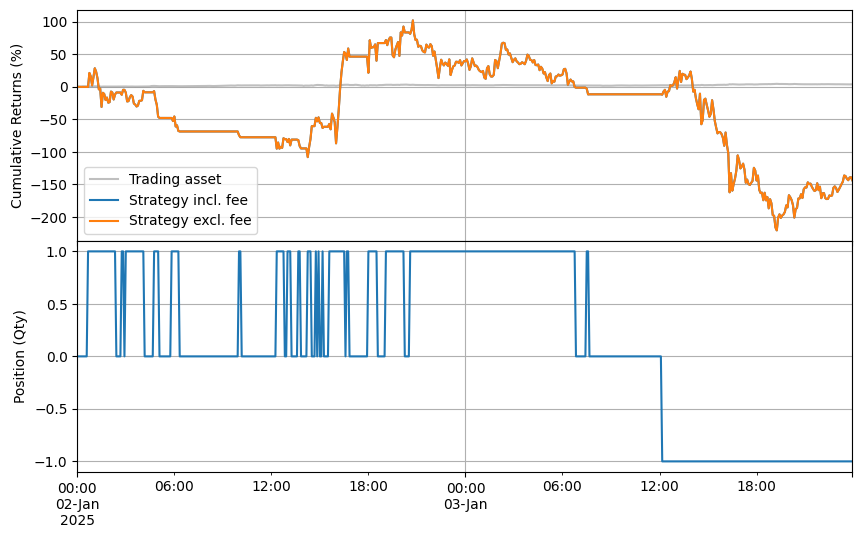

In [ ]:
stat.summary(capital = 1000)